<span style="font-size: 14pt">MIPT, Advanced ML, Autumn 2017</span>

<span style="font-size: 16pt"> HW #10: Recommender Systems

<span style="color:blue; font-size: 12pt">Andrey Saitgalin </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'"> andrey.saitgalin@gmail.com </span>

<h1 align="center">Organization Info</h1> 

* Дедлайн **18 декабря 23:59** для всех групп.
* В качестве решения задания нужно прислать ноутбук с подробными комментариями (<span style='color:red'> без присланного решения результат контеста не будет засчитан </span>).
* <span style='color:red'>Название команды в контесте должно соответствовать шаблону: НомерГруппы_Имя_Фамилия, например, 494_Ivan_Ivanov</span>.

**Оформление дз**: 
- Присылайте выполненное задание на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2017_Aut_fall <номер_группы> <фамилия>``, к примеру -- ``ML2017_Aut_fall 401 ivanov``
- Выполненное дз сохраните в файл ``<фамилия>_<группа>_task<номер>.ipnb``, к примеру -- ``ivanov_401_task10.ipnb``

**Вопросы**:
- Присылайте вопросы на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2017_Aut_fall Question <Содержание вопроса>``


--------
- **PS1**: Мы используем автоматические фильтры, и просто не найдем ваше дз, если вы не аккуратно его подпишите.
- **PS2**: Напоминаем, что дедлайны жесткие, письма пришедшие после автоматически удаляются =( чтобы соблазна не было.

<h1 align="center">Contest (100%)</h1> 
* Ссылка на контест: https://www.kaggle.com/t/f37413eb448145acba822f3a8c43946d

In [10]:
import numpy as np

import pandas as pd
from IPython.display import display

from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter


import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity


%matplotlib inline


In [11]:
train = pd.read_csv("data/train.csv")
train.head()

,rating,movieId,userId
0,3.0,2158,10953099004185006703
1,3.5,12959,10953099004185006703
2,3.5,7808,10953099004185006703
3,4.0,9049,4762492897681260571
4,3.0,12363,2110017552365950661


In [12]:
train.userId = train.userId.astype('uint64')

In [13]:
train.head(2)

,rating,movieId,userId
0,3.0,2158,10953099004185006703
1,3.5,12959,10953099004185006703


In [14]:
display(train.size)
display(train.movieId.max())
display(len(set(train.userId)))

57043719

18345

138493

In [15]:
test = pd.read_csv("data/test.csv")
test.userId = test.userId.astype('uint64')
test.head()

,movieId,userId
0,939,3128775406573976678
1,19,6058877902987009152
2,1213,2787275058272728238
3,1141,14199414671932452776
4,2935,5958052843391945803


In [19]:
user_to_compress_id = {}
compress_to_user_id = {}

def add_id_to_compress(i):
    if i not in user_to_compress_id:
        cid = len(compress_to_user_id)
        user_to_compress_id[i] = cid
        compress_to_user_id[cid] = i

for i, row in test.iterrows():
    add_id_to_compress(row.userId)
    
for i, row in train.iterrows():
    add_id_to_compress(row.userId)
        
        

In [24]:
test["userId2"] = test["userId"]

ui2 = []

for i, row in test.iterrows():
    ui2.append(user_to_compress_id[row.userId])

test["userId2"] = np.array(ui2)

display(test.head())

,movieId,userId,userId2
0,939,3128775406573976678,0
1,19,6058877902987009152,1
2,1213,2787275058272728238,2
3,1141,14199414671932452776,3
4,2935,5958052843391945803,4


In [25]:
train["userId2"] = train["userId"]

ui2 = []

for i, row in train.iterrows():
    ui2.append(user_to_compress_id[row.userId])

train["userId2"] = np.array(ui2)

display(train.head())

,rating,movieId,userId,userId2
0,3.0,2158,10953099004185006703,731
1,3.5,12959,10953099004185006703,731
2,3.5,7808,10953099004185006703,731
3,4.0,9049,4762492897681260571,3052
4,3.0,12363,2110017552365950661,125


In [28]:
#test.to_csv("test2.csv")
#train.to_csv('train2.csv')

In [33]:
import time
from scipy.sparse.linalg import svds

df = train

# df["random"] = np.random.random(size=(df.shape[0], 1))
# idx = df.sort_values(by="random") \
#     .reset_index() \
#     .groupby("userId") \
#     .head(n=7)["index"]

# mask = df.index.isin(idx)
# train_df = df[~mask]
# test_df = df[mask]

train_df = df
    
train_M = csr_matrix(
    (train_df["rating"], (train_df["userId2"], train_df["movieId"] - 1)), shape=(138493, 26744))

In [61]:

train_M_mean = train_M.mean()

U, S, Vt = svds(train_M, k=500)

In [62]:
class ErrorAggregator(object):
    def __init__(self):
        self.sum_ = 0.0
        self.count = 0
        
    def add_value(self, x, count):
        self.sum_ += x
        self.count += count
        
    def get_rmse(self):
        return np.sqrt(self.sum_ / (self.count - 1))
    
svd_error = ErrorAggregator()
mean_error = ErrorAggregator()
times = []

In [75]:
for user_id, group in train[:10000].groupby("userId2"):
    start_time = time.time()
    
    uvec = U[user_id, :] * S
    
    movie_ids = group["movieId"] - 1
    ratings = group["rating"]
    
    diff = (uvec.dot(Vt[:, movie_ids]) - ratings.values) ** 2
    svd_error.add_value(np.sum(diff), len(diff))
    
    mean_diff = (ratings.values - train_M_mean) ** 2
    mean_error.add_value(np.sum(mean_diff), len(mean_diff))
    
    times.append(time.time() - start_time)

print("RMSE:", svd_error.get_rmse())
print("Random RMSE:", mean_error.get_rmse())
print("Average evaluation time:", np.mean(times))

RMSE: 1.74153410906
Random RMSE: 3.3984461586
Average evaluation time: 0.000324730047655


2.06957236902


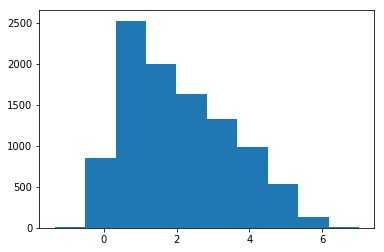

In [107]:
results = []

tt = train[:10000].copy()

for user_id, group in tt.groupby("userId2"):
    start_time = time.time()
    uvec = U[user_id, :] * S
    movie_ids = group["movieId"] - 1    
    results.append((user_id, movie_ids, uvec.dot(Vt[:, movie_ids])))

    
res2 = {}
for r in results:
    for m, ri in zip(r[1], r[2]):
        res2[(int(r[0]), int(m))] = ri
        
prating = []

for i, row in tt.iterrows():
    prating.append(res2[(int(row.userId2), int(row.movieId) - 1)])
    
tt["rating"] = np.array(prating)

print(tt.rating.mean())

plt.hist(tt.rating)
plt.show()

In [109]:
results = []

for user_id, group in test.groupby("userId2"):
    start_time = time.time()
    uvec = U[user_id, :] * S
    movie_ids = group["movieId"] - 1    
    results.append((user_id, movie_ids, uvec.dot(Vt[:, movie_ids])))


In [110]:
res2 = {}
for r in results:
    for m, ri in zip(r[1], r[2]):
        res2[(int(r[0]), int(m))] = ri

In [152]:
prating = []

for i, row in test.iterrows():
    prating.append(res2[(int(row.userId2), int(row.movieId) - 1)])

In [112]:
prating = np.array(prating)
test["rating"] = prating

In [115]:
answer = pd.read_csv('data/baseline.csv')
print(answer.rating.mean())
answer["rating"] = test["rating"]
print(answer.rating.mean())
answer.to_csv("to_send.csv", index=False)


3.65559799577
2.02593885417


In [73]:
train.rating.mean()

3.5207268919475605

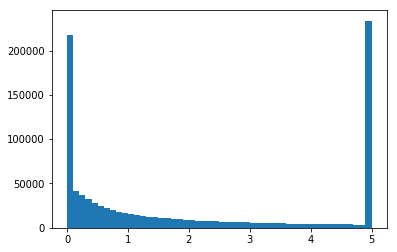

In [117]:
plt.hist(answer.rating, bins=50)
plt.show()

In [116]:
answer.rating.mean()

2.0259388541728343

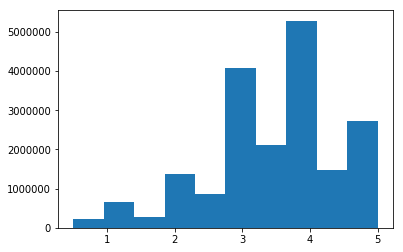

In [128]:
a = plt.hist(train.rating, bins=10)
plt.show()

In [161]:
hist_shape = a[0] / a[0].sum()
display(hist_shape)
hist_xs = np.arange(0.0, 5.1, 0.5)
display(hist_xs)
hist_pairs = list(zip(hist_xs, hist_shape))
display(hist_pairs)

array([ 0.01195515,  0.03404094,  0.01410676,  0.07200356,  0.04487432,
        0.21409095,  0.11150101,  0.27782659,  0.07696208,  0.14263865])

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ])

[(0.0, 0.011955146192344156),
 (0.5, 0.034040943228122976),
 (1.0, 0.014106759063166972),
 (1.5, 0.072003562741061816),
 (2.0, 0.044874318240015171),
 (2.5, 0.21409095013598253),
 (3.0, 0.11150100504492003),
 (3.5, 0.27782659121506437),
 (4.0, 0.076962075351363401),
 (4.5, 0.14263864878795859)]

In [170]:
def reshape(values, hist_shape, hist_xs):
    enuv = list(enumerate(values))
    values = sorted(enuv, key=lambda x: x[1])
    bounds = [0] + [int(len(enuv) * x) for x in hist_shape.cumsum()]
    bounds[-1] = len(values)
    for i in range(len(bounds) - 1):
        m = hist_xs[i]
        for j in range(bounds[i], bounds[i + 1]):
            values[j] = (values[j][0], m)
    enuv = sorted(values)
    return np.array([x[1] for x in enuv])
    

In [174]:
prating = np.array(prating)


prating2 = reshape(prating, hist_shape, hist_xs)


print(list(zip(prating[:100], prating2[:100])))

test["rating"] = prating2

answer = pd.read_csv('data/baseline.csv')
print(answer.rating.mean())
answer["rating"] = test["rating"]
print(answer.rating.mean())
answer.to_csv("to_send.csv", index=False)

[(2.0004146185108014, 4.5), (0.77973155768470881, 4.0), (-0.10389433202072285, 0.5), (0.091110423948451813, 3.0), (0.93408285034523753, 4.5), (0.18990090570225865, 3.5), (0.64315042374587983, 4.0), (1.540262964912011, 4.5), (0.61589854019460288, 4.0), (0.38265503266246081, 3.5), (0.24366460969884018, 3.5), (1.1356756941715744, 4.5), (0.97740089524565332, 4.5), (1.4250668180121935, 4.5), (0.25772741928418186, 3.5), (-0.045743775626856165, 1.5), (0.48419671339704146, 3.5), (0.34875579233441278, 3.5), (1.8395570041081037, 4.5), (0.064299194696632964, 3.0), (1.3416218636453712, 4.5), (0.23506683399962602, 3.5), (0.12728504863938372, 3.5), (1.6018283250987702, 4.5), (0.90648833697282982, 4.5), (0.091538574493111202, 3.0), (0.21000698345661073, 3.5), (0.045547750869403381, 2.5), (2.5468636948982453, 4.5), (0.084438663477466758, 3.0), (-0.02355469782577968, 1.5), (3.5989480503287967, 4.5), (0.13210806845181977, 3.5), (-0.077539578590448466, 1.0), (0.544069695187271, 3.5), (2.269283030375195, 

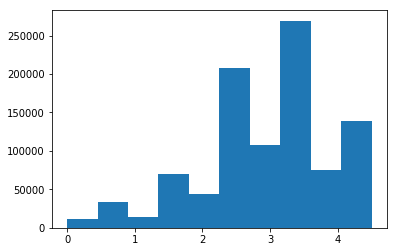

In [172]:
plt.hist(answer.rating)
plt.show()